In [65]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [66]:
D = 7

In [67]:
class QInt:
  def __init__(self, r=0, i=0, D=D):
    self.re = r
    self.im = i
    self.D = D
    if self.D % 4 == 3:
      self.hex = True
    else:
      self.hex = False

  def __add__(self, x):
    return QInt(self.re + x.re, self.im + x.im)

  def __sub__(self, x):
    return QInt(self.re - x.re, self.im - x.im)

  def __mul__(self, x):
    a = self.re
    b = self.im
    c = x.re
    d = x.im
    D = self.D
    if self.hex:
      return QInt(a*c + b*d * ((-D - 1) // 4), a*d + b*c + b*d)
    
    return QInt(a*c - D*b*d, a*d + b*c)

  def __str__(self):
    return str(self.re) + " + " + str(self.im) + f"√-{self.D}"

  def __repr__(self):
    return str(self)
  
  def __complex__(self):
    a = self.re
    b = self.im
    D = self.D
    if self.hex:
      return complex(a + 0.5 * b, (math.sqrt(D)/2) * b)
    return complex(a, math.sqrt(D) * b)
  
  def coords(self):
    return self.re, self.im

  def norm(self):
    a = self.re
    b = self.im
    D = self.D
    if self.hex:
      return a**2 + a*b + ((1+D)//4)*b**2
    return a**2 + D*b**2

  def conjugate(self):
    a = self.re
    b = self.im
    D = self.D
    if self.hex:
      return QInt(a + b, -b)
    return QInt(a, -b)

  def __truediv__(self, x):
    if x.norm() == 0:
      raise Exception("Division by zero")
    int_num = self * x.conjugate() 
    a, b = int_num.coords()
    int_den = x.norm() 
    a, b = a / int_den, b / int_den 

    return QInt(a, b)

  def real(self):
    return self.re

  def imag(self):
    return self.im

In [68]:
def embed(a, b, D=D):
    if D % 4 == 3:
        return a + 0.5 * b, (math.sqrt(D)/2) * b
    return a, math.sqrt(D) * b

In [69]:
a = QInt(10, 5)
b = QInt(5, 0)

In [70]:
def gauss_gcd_step(a, b):
  x, y = (a / b).coords()

  quotients = [(math.floor(x), math.floor(y)), (math.floor(x), math.ceil(y)), (math.ceil(x), math.floor(y)), (math.ceil(x), math.ceil(y))]

  (qx, qy) = quotients[0]
  min_norm = (a - QInt(qx, qy) * b).norm()
  for (px, py) in quotients[1:]:
    if (a - QInt(px, py) * b).norm() <= min_norm:
      qx, qy = px, py
      min_norm = (a - QInt(px, py) * b).norm()

  q = QInt(qx, qy)

  r = a - q * b

  return q, r

In [71]:
def gauss_gcd(a, b, i=1):
  _, r = gauss_gcd_step(a, b)
  r0 = r
  steps = 1
  while r.norm() > 0:
    a, b = b, r
    _, r = gauss_gcd_step(a, b)
    steps += 1
    if steps == i:
      r0 = r
  return b, steps, r0

In [72]:
a = QInt(92, 87)

grid_size = 300
dividends = [QInt(x, y) for x in range(-grid_size, grid_size) for y in range(-grid_size, grid_size)]

In [73]:
steps = []
remainders = []
for b in dividends:
  if b.norm() == 0:
    steps.append(1)
    remainders.append(0)
    continue
  _, s, r0 = gauss_gcd(a, b, i=2)
  steps.append(s)
  # c_norm = abs(complex(r0))
  # remainders.append(c_norm)
  remainders.append(r0.norm())

In [74]:
assocs = [a]

In [75]:
def circ_lines(a, m1, m2, c1, c2):
    a = complex(a)
    c = complex(c1, c2)
    m = complex(m1, m2)

    t = np.linspace(-100, 100, 10000)

    w = a / (m * t + c)

    re_x = w.real
    re_y = w.imag

    plt.plot(re_x, re_y, color='purple')

In [76]:
def circ_lines2(a, m1, m2, c1, c2, q=QInt(1,0)):
    a = complex(a)
    c = complex(c1, c2)
    m = complex(m1, m2)
    q = complex(q)

    t = np.linspace(-100, 100, 10000)

    line = m*t + c

    w = a * line / (q * line + 1)

    re_x = w.real
    re_y = w.imag

    plt.plot(re_x, re_y, color='purple')

In [77]:
def boundary_lines(D=D):
    if D % 4 == 3:
        m = -(1/math.sqrt(D))
        c = (D+1) / (4 * math.sqrt(D))

        lines = [(0, 1, 0.5, 0), (0, 1, -0.5, 0), (1, m, 0, c), (-1, -m, 0, -c), (1, -m, 0, c), (-1, m, 0, -c)]
        return lines
    lines = [(0, 1, 0.5, 0), (0, 1, -0.5, 0), (1, 0, 0, math.sqrt(D)/2), (1, 0, 0, -math.sqrt(D)/2)]
    return lines

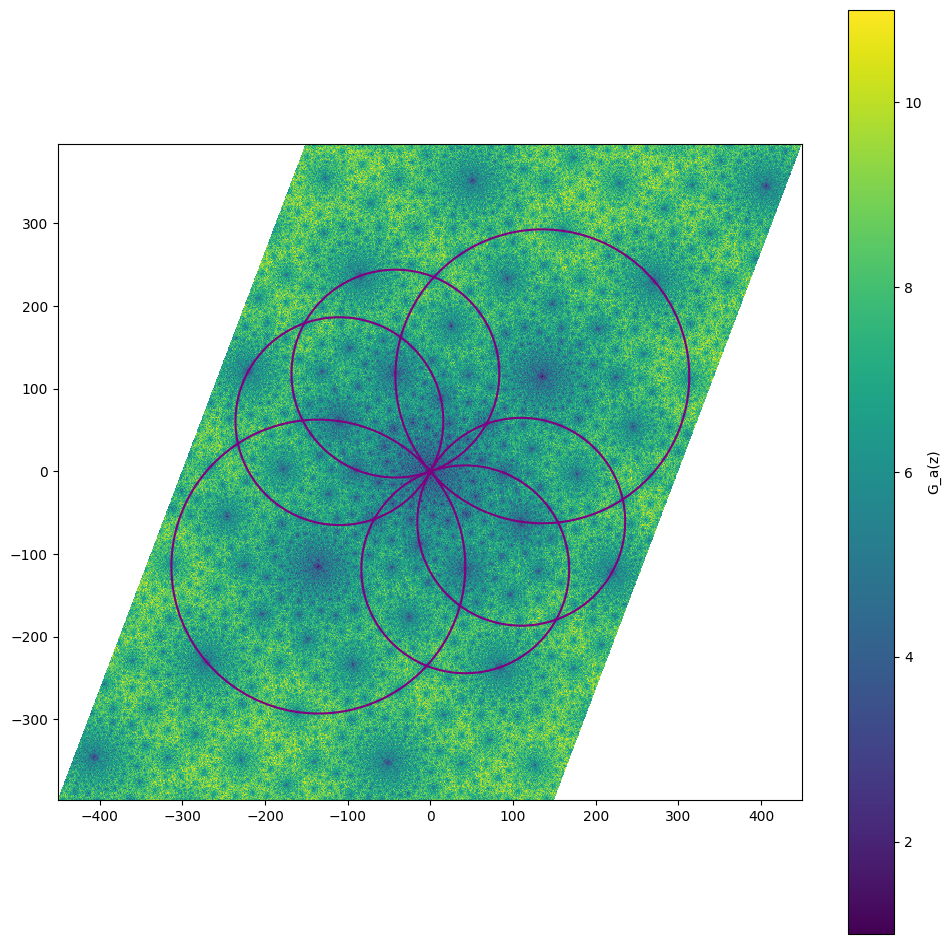

In [78]:
fig, ax = plt.subplots(figsize=(12, 12))

x, y = np.array(range(-grid_size, grid_size)), np.array(range(-grid_size, grid_size))
X, Y = np.meshgrid(x, y, indexing='ij')

X, Y = embed(X, Y)

Z = np.array(steps).reshape(len(x), len(y))

Z = np.ma.masked_where(Z <= 0, Z)

cf = ax.pcolormesh(
    X,
    Y,
    Z,
    cmap='viridis',
    shading='nearest',
    vmin=Z.min(),
    vmax=Z.max()
    # norm=LogNorm(vmin=Z.min(), vmax=Z.max())
)

cf.cmap.set_bad(color='#321543')

plt.gca().set_aspect('equal')

# for assoc in assocs:
#     as_x, as_y = embed(assoc.real(), assoc.imaginary())
#     ax.scatter(as_x, as_y, color='red', zorder=5)

b_lines = boundary_lines(D)
for (m1, m2, c1, c2) in b_lines:
    circ_lines(a, m1, m2, c1, c2)

# for (m1, m2, c1, c2) in b_lines:
#     circ_lines(a, m1, m2, c1, c2)    

# for k in [-1, 0, 1, 2]:
#     for i in [1]:
#         q1 = QInt(i, 0)
#         # q2 = G(0, i)
#         q2 = QInt(i, 0)
#         q1, q2 = complex(q1), complex(q2)
#         circ_lines2(0, 1, k+0.5, 0, q1)
#         circ_lines2(0, 1, k+0.5, 0, q2)

# for k in range(-3, 3):
#     circ_lines(a, 0, 1, k+0.5, 0)
#     circ_lines(a, 1, 0, 0, k+0.5)

plt.gca().set_aspect('equal')

cbar = plt.colorbar(cf)
cbar.set_label("G_a(z)")

plt.show()

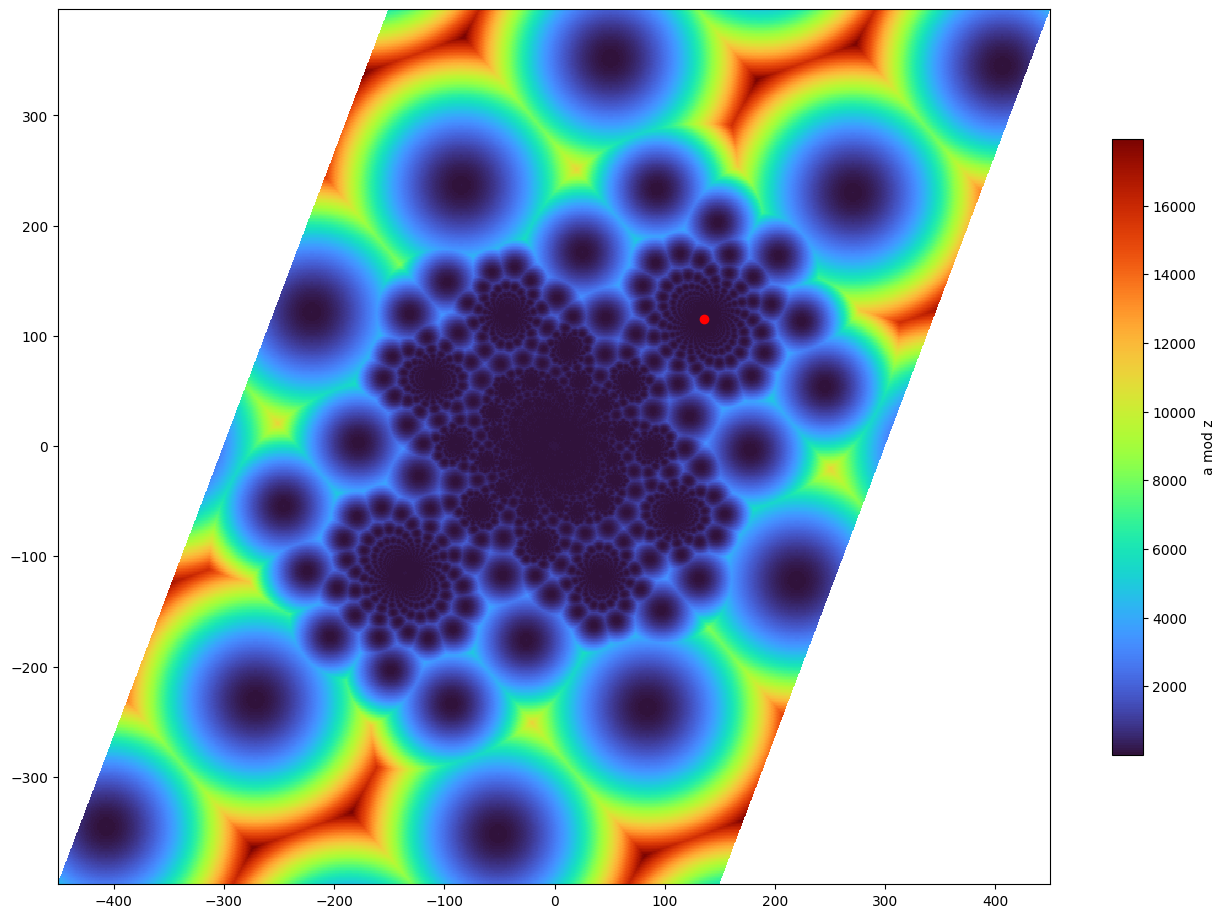

In [79]:
fig, ax = plt.subplots(figsize=(16, 16))

x, y = np.array(range(-grid_size, grid_size)), np.array(range(-grid_size, grid_size))
X, Y = np.meshgrid(x, y, indexing='ij')

X, Y = embed(X, Y)

Z = np.array(remainders).reshape(len(x), len(y))

Z = np.ma.masked_where(Z <= 0, Z)

cf = ax.pcolormesh(
    X,
    Y,
    Z,
    cmap='turbo',
    shading='nearest',
    vmin=Z.min(),
    vmax=Z.max()
    # norm=LogNorm(vmin=Z.min(), vmax=Z.max())
)

cf.cmap.set_bad(color='#321543')

for assoc in assocs:
    as_x, as_y = embed(assoc.real(), assoc.imag())
    ax.scatter(as_x, as_y, color='red', zorder=5)

# b_lines = boundary_lines(D)
# for (m1, m2, c1, c2) in b_lines:
#     circ_lines(a, m1, m2, c1, c2)

b_lines = boundary_lines(D)

# for k in [-5,-4,-3, 2, 3]:
#     for (m1, m2, c1, c2) in b_lines:
#         if abs(c1) == 0.5:
#             circ_lines2(a, m1, m2, c1+k, c2)
#         elif abs(c2) == 0.5:
#             circ_lines2(a, m1, m2, c1, c2+k)

# for k in [-5,-4,-3, 2, 3]:
#     q = QInt(1, 1)
#     for (m1, m2, c1, c2) in b_lines:
#         if abs(c1) == 0.5:
#             circ_lines2(a, m1, m2, c1+k, c2, q)
#         elif abs(c2) == 0.5:
#             circ_lines2(a, m1, m2, c1, c2+k, q)


# for (m1, m2, c1, c2) in b_lines:
#     # circ_lines2(a, m1, m2, c1, c2, q=QInt(1, 0))    
#     circ_lines2(a, 0, 1, 1.5, 0)


# for k in [-3,-2,-1,0,1, 2, 3]:
#     for i in [1]:
#         q1 = G(i, 0)
#         q2 = G(-i, 0)
#         q1, q2 = complex(q1), complex(q2)
#         circ_lines2(0, 1, k+0.5, 0, q1)
#         circ_lines2(0, 1, k+0.5, 0, q2)

ax.set_aspect('equal')

cbar = plt.colorbar(cf, shrink=0.5)
cbar.set_label("a mod z")

plt.savefig('vegasr2.png')

plt.show()

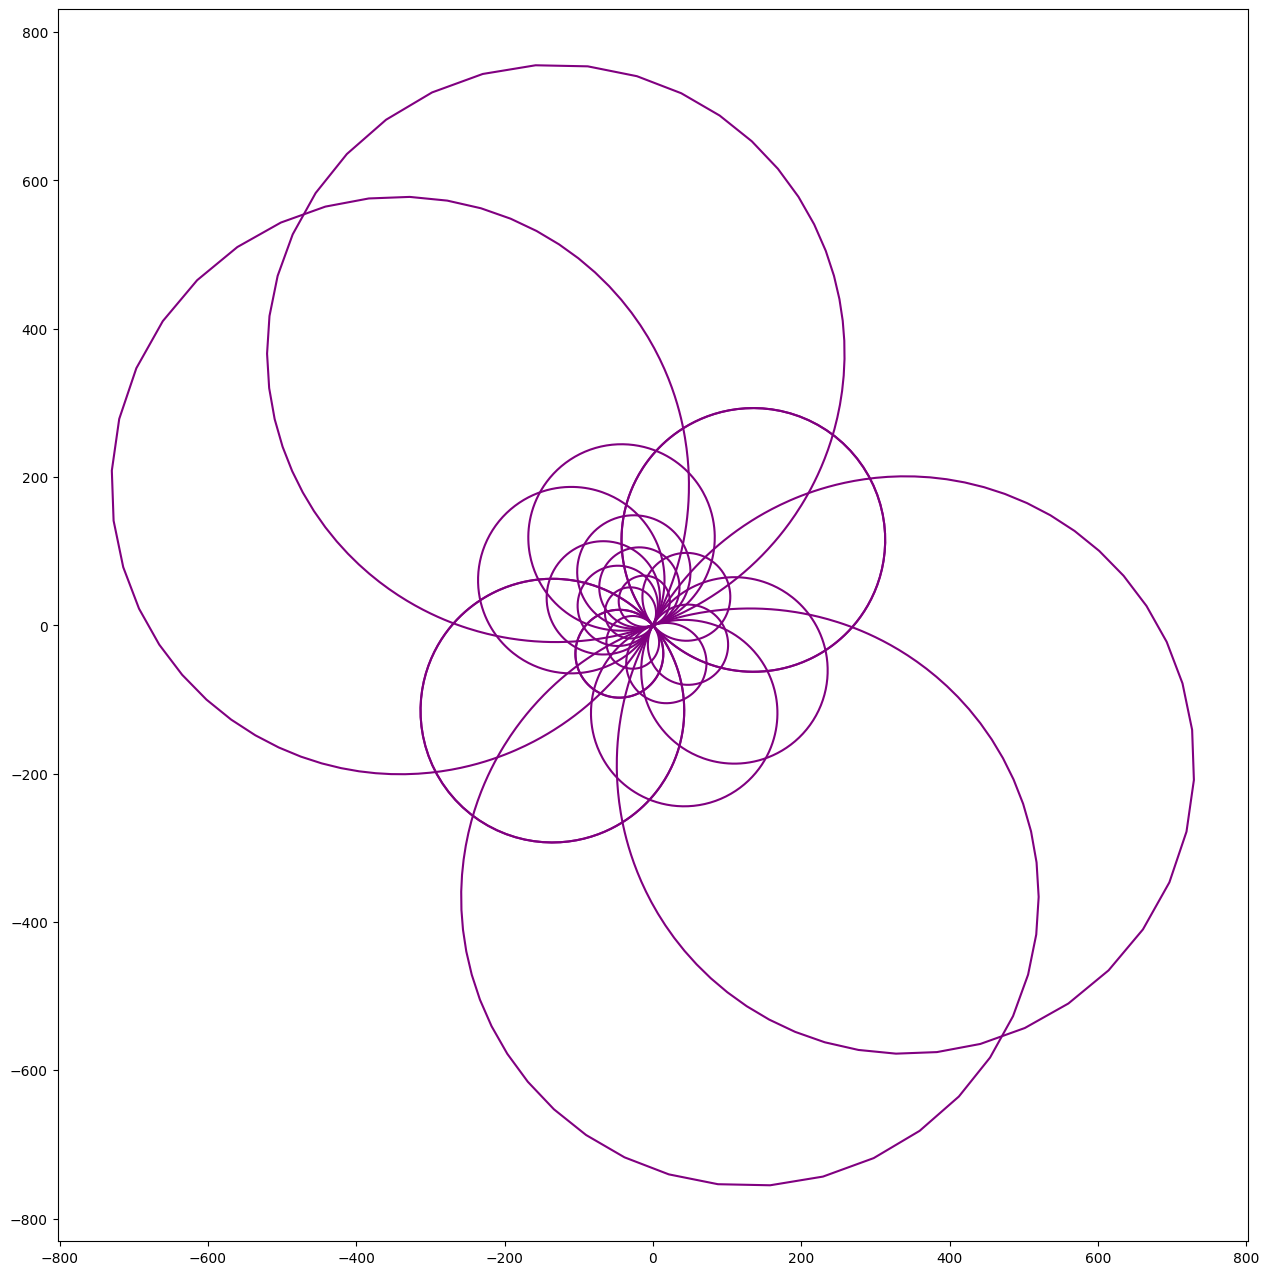

In [80]:
fig, ax = plt.subplots(figsize=(16, 16))



b_lines = boundary_lines(D)
for (m1, m2, c1, c2) in b_lines:
    for k in range(-2, 2):
        if abs(c1) == 0.5 or c1 == (D+1) / (4 * math.sqrt(D)):
            circ_lines(a, m1, m2, c1+k, c2)
        elif abs(c2) == 0.5 or abs(c2) == (D+1) / (4 * math.sqrt(D)):
            circ_lines(a, m1, m2, c1, c2+k)


# for (m1, m2, c1, c2) in b_lines:
#     # circ_lines2(a, m1, m2, c1, c2, q=QInt(1, 0))    
#     circ_lines2(a, 0, 1, 1.5, 0)


# for k in [-3,-2,-1,0,1, 2, 3]:
#     for i in [1]:
#         q1 = G(i, 0)
#         q2 = G(-i, 0)
#         q1, q2 = complex(q1), complex(q2)
#         circ_lines2(0, 1, k+0.5, 0, q1)
#         circ_lines2(0, 1, k+0.5, 0, q2)

ax.set_aspect('equal')

plt.savefig('gaussr2hollow.png')

plt.show()